<a href="https://colab.research.google.com/github/qinalan10/cs598-patient-phenotyping/blob/master/Code/DLH_Patient_Phenotyping_Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a CNN Model for Patient Phenotyping Based on Patient Notes

*   Read the file containing the patient notes and annoations
*   Clean the text data
*   Create Train, Validation and Test Data Split
*   Train a Word2Vec Model
*   Create Word Embeddings using the Word2Vec Model
*   Create CNN Classfier
*   Train & Validate the Classifier
*   Test Model Performance











In [ ]:
# importing libaries
from google.colab import files
from google.colab import drive
import pandas as pd 
import torch
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import re 
import numpy as np 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score   
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
drive.mount('/content/drive')

Mounted at /content/drive


# Use GPU if Available

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


Setting Paths & Read the Final File

In [ ]:
path = '/content/drive/MyDrive/Data/NOTEEVENTS.csv'
annotations_path = "/content/drive/MyDrive/Data/annotations.csv"
final_file_path = "/content/drive/MyDrive/Data/final_file.csv"

In [ ]:
dataframe = pd.read_csv(final_file_path)
dataframe.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
class HealthcareTextDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.text_data = self.data['TEXT']
        self.labels = torch.tensor(np.array(self.data.iloc[:, :-1]), dtype = torch.float, device=device)  # assuming the labels are in the first 14 columns
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.text_data.iloc[idx]
        labels = self.labels[idx]
        sample = {'text': text, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
# Stop words
import nltk
nltk.download('stopwords')
stp_wrds = stopwords.words('english')
stp_wrds.extend(["uncle", "grandmother", "grandfather"])
print(stp_wrds)
stop_words = set(stp_wrds)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Tokenize the data
tokenizer = get_tokenizer('basic_english')

import string
# Define a custom data transformation function
def transform_fn(sample):
    text = sample['text']
    labels = sample['labels']

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'\d+', '', text) # maybe don't remove, could be important 
    
    # Tokenize text data
    text = tokenizer(text)

    filtered_words  = []
    for word in text:
      if word not in stop_words:
        filtered_words.append(word)
    text = filtered_words

    # Convert labels to PyTorch tensor
    return {'text': text, 'labels': labels}

In [ ]:
dataset = HealthcareTextDataset(dataframe, transform_fn)

In [ ]:
def collate_fn(batch):
    texts = [item['text'] for item in batch]  # Extract the text data from the batch
    labels = [item['labels'] for item in batch]  # Extract the labels from the batch

    # Find the maximum length of text sequences in the batch
    max_len = max([len(text) for text in texts])

    # Pad the text sequences with a padding token (e.g., '<pad>') to the maximum length
    padded_texts = []
    for text in texts:
      padded_text = text + ['<pad>'] * (max_len - len(text))
      padded_texts.append(padded_text)

    # Convert the labels to a PyTorch tensor
    labels = torch.stack(labels)

    return {'text': padded_texts, 'labels': labels}

In [ ]:
# Setting up random seed
torch.manual_seed(456)

# Create train, test and validation split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Training a Word2Vec Model

In [ ]:
from gensim.models import Word2Vec

corpus_processed = []
for i in train_dataset:
  corpus_processed.append(i['text'])

RANDOM_SEED = 23432098
VEC_SIZE = 300
MIN_COUNT = 5
sg = 0 # 0 is CBOW, 1 is skip gram
w2v_model = Word2Vec(sentences=corpus_processed, 
                     vector_size= VEC_SIZE, 
                     min_count = MIN_COUNT, 
                     workers=1, 
                     seed = RANDOM_SEED, 
                     sg=sg, 
                     epochs=15,
                     window=10,
                     negative=10)

# Create Word Embeddings

In [ ]:
kv = w2v_model.wv
kv.vectors
#then convert to kv.vectors to tensor
embeddings = torch.tensor(kv.vectors, device=device)
print(embeddings.shape)
print(embeddings)

torch.Size([10315, 300])
tensor([[-1.6004e+00, -4.0572e-02,  1.4913e+00,  ...,  5.6209e-01,
         -1.4693e+00,  6.5162e-01],
        [-8.4426e-01, -3.9578e-01,  2.7766e-01,  ..., -6.4214e-02,
          3.8522e-01,  8.1983e-01],
        [ 8.6164e-01, -4.8736e-02,  2.9800e-01,  ...,  5.4254e-01,
          4.4704e-01,  1.1246e+00],
        ...,
        [-6.1528e-03, -4.5394e-02, -7.8702e-02,  ...,  6.1781e-02,
         -2.5810e-02, -6.7572e-02],
        [-1.3252e-01, -3.2614e-02,  1.5242e-01,  ..., -1.7464e-01,
          9.4650e-02, -5.6039e-03],
        [ 1.0066e-01,  4.4941e-04, -1.7577e-01,  ..., -1.9175e-01,
          1.4803e-01, -6.0401e-02]], device='cuda:0')


Create a Function to look at some word similarities to see how well the model has been trained.

In [ ]:
#input: model: word2vec model
#       word: a single word, e.g. 'heart'
#output: list_of_words: a list of words similar to the given word
def similar_word(model, word):
    
    list_of_words = []

    # your code here
    tup_of_words = model.wv.most_similar(word)
    list_of_words = list(map(lambda x: x[0], tup_of_words))
    return list_of_words

The results look promising for 'cancer', ' obesity' and 'heart'. The result for 'blood' doesn't look that accurate.

In [ ]:
word = 'cancer'
assert type(similar_word(w2v_model, word)) is list
print("The words similar to '%s' are: '%s'." % (word, ', '.join(similar_word(w2v_model, word))))

word = 'obesity'
assert type(similar_word(w2v_model, word)) is list
print("The words similar to '%s' are: '%s'." % (word, ', '.join(similar_word(w2v_model, word))))

word = 'blood'
assert type(similar_word(w2v_model, word)) is list
print("The words similar to '%s' are: '%s'." % (word, ', '.join(similar_word(w2v_model, word))))

word = 'heart'
assert type(similar_word(w2v_model, word)) is list
print("The words similar to '%s' are: '%s'." % (word, ', '.join(similar_word(w2v_model, word))))

The words similar to 'cancer' are: 'ca, mets, adenocarcinoma, carcinoma, nsclc, rcc, tumor, xrt, breast, lymphoma'.
The words similar to 'obesity' are: 'morbid, osa, migraines, asthma, apnea, oa, osteoarthritis, hypoventilation, osteoporosis, cataracts'.
The words similar to 'blood' are: 'dropped, support, pcwpmmhg, sent, high, nailbed, urine, yearmonthday, estimated, surveillance'.
The words similar to 'heart' are: 'thrive, multiorgan, resp, cardiac, sedimentation, cardiovascular, respiratory, respitory, repiratory, congestive'.


In [ ]:
w2v_index = kv.index_to_key
print(w2v_index[1:100])
print(len(w2v_index))

['po', 'name', 'tablet', 'patient', 'blood', 'sig', 'daily', 'hospital', 'one', 'day', 'discharge', 'history', 'last', 'left', 'pm', 'admission', 'right', 'pain', 'pt', 'date', 'namepattern', 'ct', 'medications', 'times', 'normal', 'chest', 'first', 'given', 'also', 'status', 'hours', 'sp', 'course', 'disease', 'every', 'continued', 'needed', 'home', 'stable', 'well', 'capsule', 'started', 'please', 'care', 'md', 'days', 'two', 'per', 'bid', 'negative', 'qh', 'un', 'hct', 'refills', 'x', 'showed', 'prior', 'stitle', 'time', 'tablets', 'wbc', 'medical', 'likely', 'disp', 'dr', 'seen', 'past', 'acute', 'renal', 'pulmonary', 'glucose', 'iv', 'service', 'patients', 'urine', 'release', 'chronic', 'edema', 'noted', 'followup', 'failure', 'due', 'qd', 'l', 'instructions', 'heart', 'prn', 'exam', 'present', 'artery', 'family', 'plt', 'mild', 'known', 'admitted', 'rbc', 'tid', 'without', 'pressure']
10315


In [ ]:
def word2idx(w2v_index):
    word_to_idx = {'<pad>':0}
    idx = 1
    for word in w2v_index:
        if word not in word_to_idx:
            word_to_idx[word] = idx
            idx += 1
    return word_to_idx

In [ ]:
w2v_dictionary = word2idx(w2v_index)

In [ ]:
idx_0 = torch.zeros(1, 300, device = device)
embeddings = torch.cat((idx_0, embeddings))

# Fitting a CNN Classifier

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random 

class CNNClassifier(nn.Module):
    def __init__(self, embedding_dim, num_filters, filter_sizes, embeddings, output_size, w2v_dictionary):
        super(CNNClassifier, self).__init__()
        self.dictionary = w2v_dictionary
        self.embedding = nn.Embedding.from_pretrained(embeddings)#(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, num_filters, filter_sizes[0])
        self.conv2 = nn.Conv1d(embedding_dim, num_filters, filter_sizes[1])
        self.conv3 = nn.Conv1d(embedding_dim, num_filters, filter_sizes[2])
        self.conv4 = nn.Conv1d(embedding_dim, num_filters, filter_sizes[3])
        self.conv5= nn.Conv1d(embedding_dim, num_filters, filter_sizes[4])
        self.dropout = nn.Dropout(p = 0.1)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_size)
        
    def forward(self, x):
      # change to indexes, then to tensor
        z2 = []
        for ls in x:
          z1 = []
          for word in ls:
            if word not in self.dictionary.keys():
              random_key = random.sample(list(self.dictionary.keys()), 1)[0]
              z1.append(self.dictionary[random_key])
            else:
              z1.append(self.dictionary[word])
          z2.append(z1)  

        x = torch.tensor(z2, device = device)
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Permute the dimensions for Conv1d (batch_size, embedding_dim, sequence_length)

        x1 = F.relu(self.conv1(x))
        x1 = F.max_pool1d(x1 , x1.size(2)).squeeze(2)

        x2 = F.relu(self.conv2(x))
        x2 = F.max_pool1d(x2 , x2.size(2)).squeeze(2)

        x3 = F.relu(self.conv3(x))
        x3 = F.max_pool1d(x3 , x3.size(2)).squeeze(2)

        x4 = F.relu(self.conv4(x))
        x4 = F.max_pool1d(x4 , x4.size(2)).squeeze(2)

        x5 = F.relu(self.conv4(x))
        x5 = F.max_pool1d(x5 , x5.size(2)).squeeze(2)

        out = torch.cat((x1, x2, x3, x4, x5), 1)
        out = self.dropout(out)
        out = self.fc(out)

        out = torch.sigmoid(out)

        return out

# Setting up the model Parameters

In [ ]:
# Parametrs
embedding_dim = 300
num_filters = 256
filter_sizes = [1, 2, 3, 4, 5]
output_size = 14

model = CNNClassifier(embedding_dim, num_filters, filter_sizes, embeddings, output_size, w2v_dictionary)

model.to(device)

# Print a model sumary
#summary(model, input_size=(1600, 10), batch_size=-1)

CNNClassifier(
  (embedding): Embedding(10316, 300)
  (conv1): Conv1d(300, 256, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(300, 256, kernel_size=(2,), stride=(1,))
  (conv3): Conv1d(300, 256, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(300, 256, kernel_size=(4,), stride=(1,))
  (conv5): Conv1d(300, 256, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1280, out_features=14, bias=True)
)

In [ ]:
# Criterion
criterion = nn.BCELoss()

# Optimizer
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.05, eps=1e-06)

# Training the Model

In [ ]:
# Train Model
def train_model(model, train_dataloader, val_dataloader, epochs=20, optimizer=optimizer, criterion=criterion):
  model.to(device)
  curr_epoch_loss_avg =[]
  val_loss_avg = []
  for epoch in range(epochs):
      model.train()
      curr_epoch_loss = []
      
      for batch in tqdm(train_dataloader):
          text = batch['text']
          labels = batch['labels']#.long().flatten()
          optimizer.zero_grad()
          outputs = model(text)#.flatten()
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          curr_epoch_loss.append(loss.cpu().data.numpy())
      curr_epoch_loss_avg.append(np.mean(curr_epoch_loss))
      print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss):.3f}")
      
      # Evaluation
      model.eval()
      val_loss = 0.0
      
      Y_shuffled, Y_preds, losses = [],[],[]
      with torch.no_grad():
          for batch in val_dataloader:
              text = batch['text']
              labels = batch['labels']#.long().flatten()
              outputs = model(text)#.flatten()
              val_loss += criterion(outputs, labels).item()  
              
              loss = criterion(outputs, labels)
              losses.append(loss.item())

      avg_val_loss = val_loss / len(val_dataloader)
      val_loss_avg.append(avg_val_loss)

      print(f'Epoch [{epoch+1}/{epochs}], Val Loss: {avg_val_loss:.3f}')
      #print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled, Y_preds)))
  return (model, curr_epoch_loss_avg, val_loss_avg)

In [ ]:
n_epochs = 100
import time
start_time = time.time()
trained_model, train_loss, val_loss = train_model(model, train_loader, val_loader, n_epochs)
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 21/21 [00:12<00:00,  1.71it/s]


Epoch 90: curr_epoch_loss=0.174
Epoch [91/100], Val Loss: 0.305


100%|██████████| 21/21 [00:12<00:00,  1.71it/s]


Epoch 91: curr_epoch_loss=0.174
Epoch [92/100], Val Loss: 0.308


100%|██████████| 21/21 [00:12<00:00,  1.65it/s]


Epoch 92: curr_epoch_loss=0.170
Epoch [93/100], Val Loss: 0.305


100%|██████████| 21/21 [00:12<00:00,  1.66it/s]


Epoch 93: curr_epoch_loss=0.169
Epoch [94/100], Val Loss: 0.309


100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


Epoch 94: curr_epoch_loss=0.169
Epoch [95/100], Val Loss: 0.309


100%|██████████| 21/21 [00:12<00:00,  1.66it/s]


Epoch 95: curr_epoch_loss=0.165
Epoch [96/100], Val Loss: 0.307


100%|██████████| 21/21 [00:12<00:00,  1.67it/s]


Epoch 96: curr_epoch_loss=0.164
Epoch [97/100], Val Loss: 0.304


100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


Epoch 97: curr_epoch_loss=0.166
Epoch [98/100], Val Loss: 0.306


100%|██████████| 21/21 [00:12<00:00,  1.70it/s]


Epoch 98: curr_epoch_loss=0.161
Epoch [99/100], Val Loss: 0.311


100%|██████████| 21/21 [00:12<00:00,  1.70it/s]


Epoch 99: curr_epoch_loss=0.162
Epoch [100/100], Val Loss: 0.313


# Training Loss vs Validation Loss

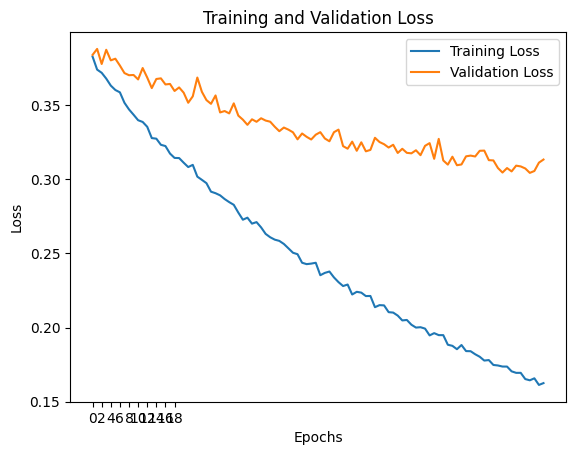

In [ ]:
from matplotlib.pylab import plt
from numpy import arange
 
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 100)
 
# Plot and label the training and validation loss values
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 20, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

# Evaluate Model Function 

In [ ]:
def eval_model(model, dataloader):
    model.eval()
    Y_pred = []
    Y_true = []
    with torch.no_grad():
        for batch in dataloader:
            text = batch['text']
            labels = batch['labels']
            pred = model(text).cpu()
            pred=np.round(pred)
            Y_pred.append(pred.numpy())
            Y_true.append(labels.cpu().numpy())
        Y_pred = np.concatenate(Y_pred, axis = 0)
        Y_true = np.concatenate(Y_true, axis = 0)
    return Y_pred, Y_true

Make Predictions on the Test Data -

In [ ]:
y_pred, y_true = eval_model(trained_model, test_loader)

# Evaluating the Model Performance

In [ ]:
target_classes =['Obesity', 'Non.Adherence', 'Developmental.Delay.Retardation',
               'Advanced.Heart.Disease', 'Advanced.Lung.Disease',
               'Schizophrenia.and.other.Psychiatric.Disorders', 'Alcohol.Abuse',
               'Other.Substance.Abuse', 'Chronic.Pain.Fibromyalgia',
               'Chronic.Neurological.Dystrophies', 'Advanced.Cancer', 'Depression',
               'Dementia', 'Unsure']

# Collecting the Predcitions and Truth

print("Test Accuracy : {}".format(accuracy_score(y_true, y_pred), zero_division=1))
print("\nClassification Report : ")
print(classification_report(y_true, y_pred, target_names=target_classes, zero_division=1))

Test Accuracy : 0.20118343195266272

Classification Report : 
                                               precision    recall  f1-score   support

                                      Obesity       1.00      0.00      0.00        11
                                Non.Adherence       0.50      0.07      0.12        14
              Developmental.Delay.Retardation       1.00      0.00      0.00         3
                       Advanced.Heart.Disease       0.70      0.58      0.64        36
                        Advanced.Lung.Disease       0.00      0.00      0.00        17
Schizophrenia.and.other.Psychiatric.Disorders       0.79      0.29      0.42        38
                                Alcohol.Abuse       0.79      0.71      0.75        21
                        Other.Substance.Abuse       0.50      0.36      0.42        11
                    Chronic.Pain.Fibromyalgia       0.83      0.18      0.29        28
             Chronic.Neurological.Dystrophies       0.42      0.51 

# AUC Score & Accuracy

In [ ]:
y_t = y_true.transpose()
y_p = y_pred.transpose()
auc_list = []
acc_list = []
for i in range(len(y_t)):
  auc = roc_auc_score(y_t[i], y_p[i], average=None)
  acc = accuracy_score(y_t[i], y_p[i], normalize= True)
  auc_list.append(auc)
  acc_list.append(acc)
  print(f'{target_classes[i]} : AUC - {auc:.2f}, Accuracy - {acc:.2f}')


Obesity : AUC - 0.50, Accuracy - 0.93
Non.Adherence : AUC - 0.53, Accuracy - 0.92
Developmental.Delay.Retardation : AUC - 0.50, Accuracy - 0.98
Advanced.Heart.Disease : AUC - 0.76, Accuracy - 0.86
Advanced.Lung.Disease : AUC - 0.49, Accuracy - 0.89
Schizophrenia.and.other.Psychiatric.Disorders : AUC - 0.63, Accuracy - 0.82
Alcohol.Abuse : AUC - 0.84, Accuracy - 0.94
Other.Substance.Abuse : AUC - 0.67, Accuracy - 0.93
Chronic.Pain.Fibromyalgia : AUC - 0.59, Accuracy - 0.86
Chronic.Neurological.Dystrophies : AUC - 0.66, Accuracy - 0.75
Advanced.Cancer : AUC - 0.69, Accuracy - 0.93
Depression : AUC - 0.60, Accuracy - 0.76
Dementia : AUC - 0.50, Accuracy - 0.89
Unsure : AUC - 0.50, Accuracy - 0.89


# AUC Score Plot

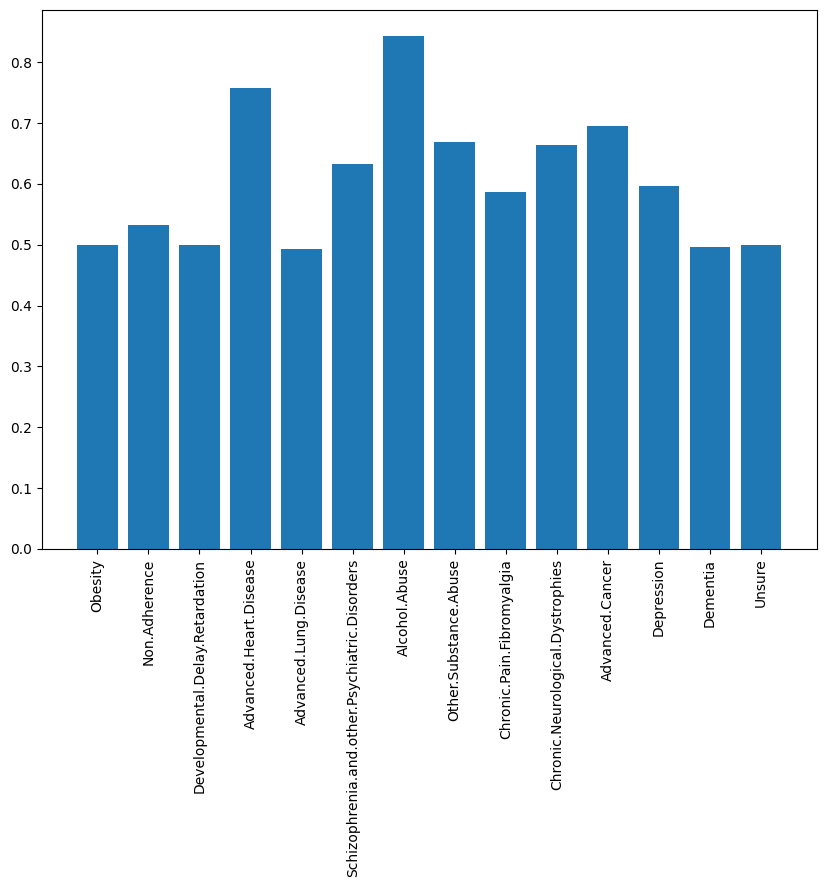

In [ ]:
from matplotlib import pyplot as plt
 
# Figure Size
fig = plt.figure(figsize =(10, 7))


# Horizontal Bar Plot
plt.bar(target_classes, auc_list)
plt.xticks(rotation='vertical') 

# Show Plot
plt.show()

# Accuracy Score Plot

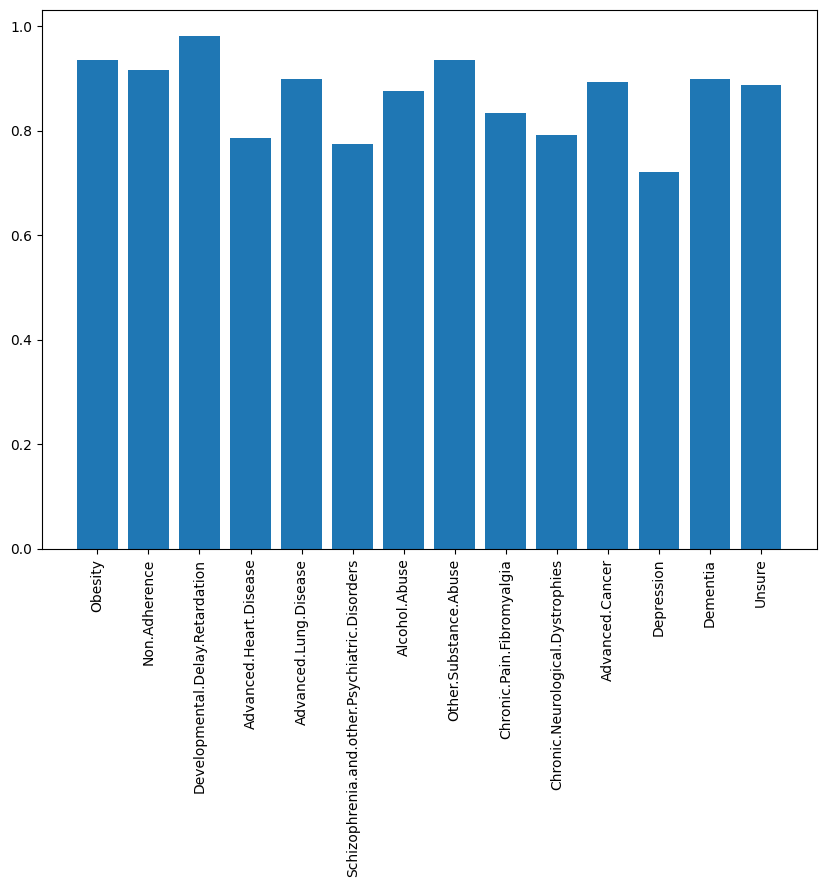

In [ ]:
from matplotlib import pyplot as plt
 
# Figure Size
fig = plt.figure(figsize =(10, 7))


# Horizontal Bar Plot
plt.bar(target_classes, acc_list)
plt.xticks(rotation='vertical') 
# Show Plot
plt.show()

In [ ]:
# Model Path
PATH = '/content/drive/MyDrive/Data/Experiment_1.pth'

# Save the Model
torch.save(trained_model, PATH)

# Load the model
trained_model = torch.load(PATH)

# Print the Model
print(trained_model)

CNNClassifier(
  (embedding): Embedding(10316, 300)
  (conv1): Conv1d(300, 256, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(300, 256, kernel_size=(2,), stride=(1,))
  (conv3): Conv1d(300, 256, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(300, 256, kernel_size=(4,), stride=(1,))
  (conv5): Conv1d(300, 256, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1280, out_features=14, bias=True)
)
